TODO: 
* modify pipeline, more options
* test data as whole, not couple of chunks
* visualisation for diagnosing


Architectures:
* conv2d
* cnn + lstm: https://stats.stackexchange.com/questions/252095/sequence-classification-via-neural-networks

In [1]:
from IPython.core.debugger import set_trace

In [2]:
import numpy as np
from numpy.random import seed
seed(1)
#display all values from array
np.set_printoptions(threshold=np.nan)
#display not in scientific format
np.set_printoptions(suppress=True)

# from tensorflow import set_random_seed
# set_random_seed(2)

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

import pickle
INPUT_DATA_FILE_PATH='tmp/input.pckl'

In [3]:
DATA_FREQUENCY = 500
SAMPLING_RATE = 5
FREQUENCY_TO_SAMPLING_RATIO = DATA_FREQUENCY // SAMPLING_RATE
CHUNK_SIZE_IN_SECONDS = 4

In [4]:
from data_reader import read_data

def load_data_to_file():
    (input_data, target, headers) = read_data(data_path='data', 
                                              sampling_rate=SAMPLING_RATE, 
                                              data_frequency=DATA_FREQUENCY)

    with open(INPUT_DATA_FILE_PATH, 'wb') as input_variable_file:
        pickle.dump([input_data, target, headers], input_variable_file)

    del input_data, target, headers
    
# load_data_to_file()

In [5]:
from chunks_creator import prepare_chunks
from chunks_creator import flatten_chunks

def normalize(x, y):
    scalers = {}
    for channel_number in range(x.shape[1]):
        scalers[channel_number] = StandardScaler()
        x[:, channel_number, :] = scalers[channel_number].fit_transform(x[:, channel_number, :]) 
    return x, y.astype(int)


def load_input_data():
    with open(INPUT_DATA_FILE_PATH, 'rb') as input_data_file:
        input_data, target, headers = pickle.load(input_data_file)
    
    return input_data, target, headers


def prepare_data():
    input_data, target, headers = load_input_data()
    
    chunks_input, chunks_target = prepare_chunks(input_data, 
                                                target, 
                                                chunk_size_in_seconds=CHUNK_SIZE_IN_SECONDS, 
                                                ratio=FREQUENCY_TO_SAMPLING_RATIO)
    x, y = flatten_chunks(chunks_input, chunks_target)
    x, y = normalize(x, y)
    
    return x, y

# cut to here

In [6]:
from keras.models import Sequential
from keras.models import Sequential

from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, LSTM, BatchNormalization, Activation

from keras.optimizers import RMSprop, SGD

from keras import callbacks

from keras.constraints import maxnorm

Using TensorFlow backend.


In [7]:
from time import time
import datetime

def create_current_time():
    timestamp = time()
    return datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')

In [8]:
def callbacks_list(description): 
    return [
#     callbacks.EarlyStopping(
#         monitor='val_acc', 
#         patience=5
#     ),
    callbacks.ModelCheckpoint(
        filepath='tmp/best_model.h5', 
        monitor='val_loss', 
        save_best_only=True
    ),
    callbacks.TensorBoard(
        log_dir='tmp/logs/{}:{}'.format(description, create_current_time()),
        histogram_freq=0, #it has to be 0, otherwise throws error during training
        write_graph=True,
        write_images=True
    )
]

In [9]:
import inspect

def get_function_name():
    return inspect.stack()[1][3]

In [10]:
def load_data_kfold(folds_number):
    x, y = prepare_data()
    
    x_train, x_test, y_train, y_test = train_test_split(x, 
                                                        y, 
                                                        test_size=0.05)
    
    folds = list(StratifiedKFold(n_splits=folds_number, 
                                 shuffle=True, 
                                 random_state=1).split(x_train, y_train))
    
    return folds, x_train, y_train, x_test, y_test

In [11]:
# ~70-80% test, overfitting
def conv_1D_62_32(input_shape):
    description = get_function_name()
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model, description

#less overfitting
def conv_1D_smaller_32_16(input_shape):
    description = get_function_name()
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=6, padding='same', activation='relu', input_shape=input_shape))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=16, kernel_size=6, padding='same', activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model, description


def testing(input_shape):
    description = get_function_name()
    
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=6, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=16, kernel_size=6, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model, description


def baseline(input_shape):
    description = get_function_name()
    
    model = Sequential()
    model.add(Dense(60, kernel_initializer='normal', activation='relu', input_shape=input_shape))
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model, description

In [12]:
def run_pipeline(create_model, folds, epochs, learning_rate):
    score = []
    best_model_score = []
    
    for fold_number, (train_idx, val_idx) in enumerate(folds):
        print('\nFold: ', fold_number + 1)
        x_train_cv = x_train[train_idx]
        y_train_cv = y_train[train_idx]
        x_valid_cv = x_train[val_idx]
        y_valid_cv = y_train[val_idx]
                
        input_shape = x_train.shape[1:]

        model, model_description = create_model(input_shape)
        
        description = "lr = {}".format(learning_rate)

        callbacks = callbacks_list("{}. {}-{}".format(model_description, 
                                                      description, 
                                                      fold_number))

        model.compile(optimizer=RMSprop(lr=learning_rate),
                      loss='binary_crossentropy',
                      metrics=['acc'])

        history = model.fit(x_train_cv,
                            y_train_cv,
                            epochs=epochs,
                            batch_size=16,
                            callbacks=callbacks,
                            validation_data=(x_valid_cv, y_valid_cv),
                            verbose=0)

        score.append(model.evaluate(x_valid_cv, y_valid_cv, batch_size=16, verbose=0))

        model.load_weights("tmp/best_model.h5")
        best_model_score.append(model.evaluate(x_valid_cv, y_valid_cv, batch_size=16, verbose=0))
        
        print("--Last epoch validation accuracy: %.2f%%" % (score[fold_number][1]*100))
        print("--Best model validation accuracy: %.2f%%" % (best_model_score[fold_number][1]*100))
        
    return score, best_model_score

In [13]:
folds, x_train, y_train, x_test, y_test = load_data_kfold(folds_number=10)

In [14]:
score, best_model_score = run_pipeline(create_model=conv_1D_smaller_32_16,
                                       folds=folds,
                                       epochs=100,
                                       learning_rate=3e-5)

avg_accuracy = np.mean([row[1] for row in best_model_score])
print("Average best models validation accuracy: {}".format(avg_accuracy))


Fold:  1
--Last epoch validation accuracy: 68.75%
--Best model validation accuracy: 66.07%

Fold:  2
--Last epoch validation accuracy: 74.11%
--Best model validation accuracy: 73.21%

Fold:  3
--Last epoch validation accuracy: 74.11%
--Best model validation accuracy: 75.89%

Fold:  4
--Last epoch validation accuracy: 75.00%
--Best model validation accuracy: 75.00%

Fold:  5
--Last epoch validation accuracy: 70.54%
--Best model validation accuracy: 71.43%

Fold:  6
--Last epoch validation accuracy: 75.00%
--Best model validation accuracy: 73.21%

Fold:  7
--Last epoch validation accuracy: 75.00%
--Best model validation accuracy: 77.68%

Fold:  8
--Last epoch validation accuracy: 72.32%
--Best model validation accuracy: 61.61%

Fold:  9
--Last epoch validation accuracy: 63.06%
--Best model validation accuracy: 67.57%

Fold:  10
--Last epoch validation accuracy: 71.82%
--Best model validation accuracy: 73.64%
Average best models validation accuracy: 0.7153110740054236


In [15]:
def plot_results(history):
    import matplotlib.pyplot as plt

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
# plot_results(history)
# using view in tensorboard instead

In [16]:
from plots_printer import draw_plots, draw_plots_with_chunks

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]

input_data, target, headers = load_input_data()
chunks_input, chunks_target = prepare_chunks(input_data, 
                                            target, 
                                            chunk_size_in_seconds=CHUNK_SIZE_IN_SECONDS, 
                                            ratio=FREQUENCY_TO_SAMPLING_RATIO)

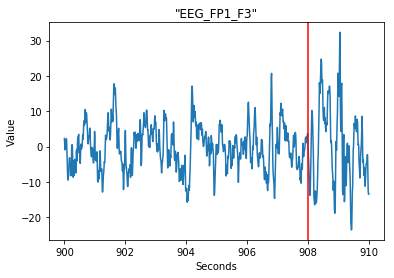

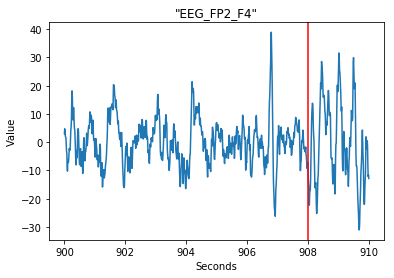

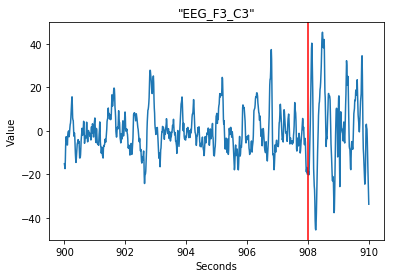

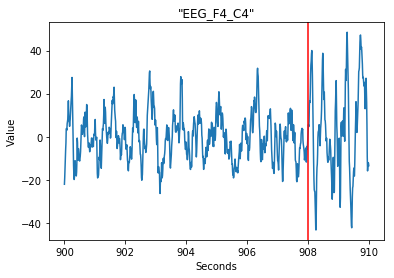

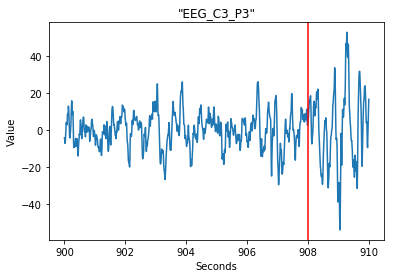

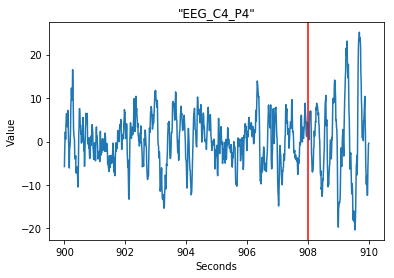

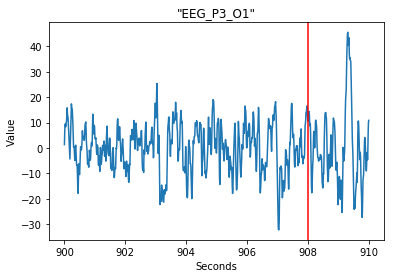

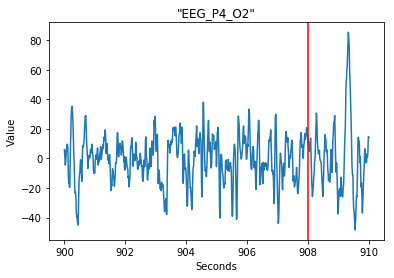

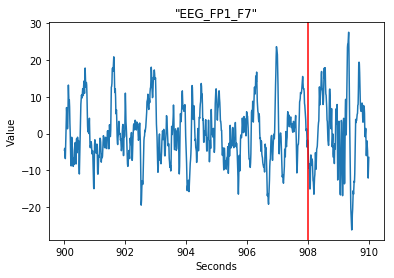

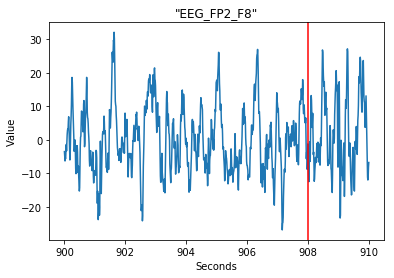

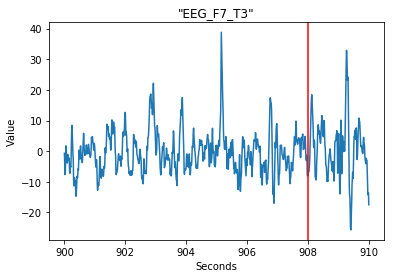

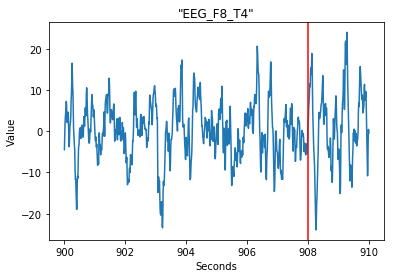

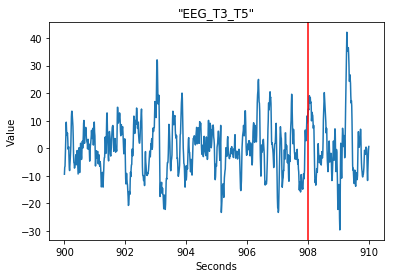

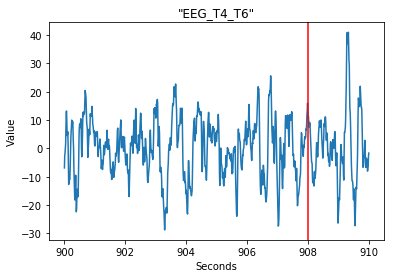

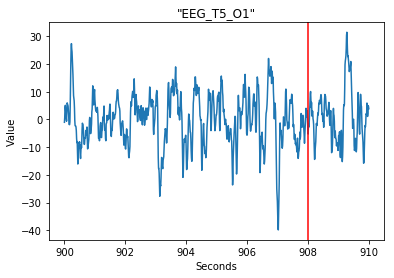

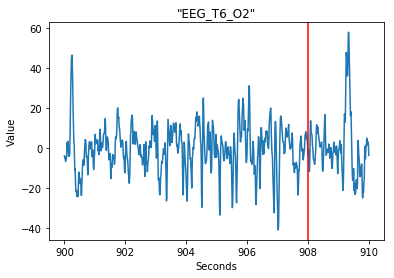

In [17]:
draw_plots(input_data, 
           target, 
           headers, 
           patient=0, 
           start_second=900, 
           end_second=910,
           ratio=FREQUENCY_TO_SAMPLING_RATIO)

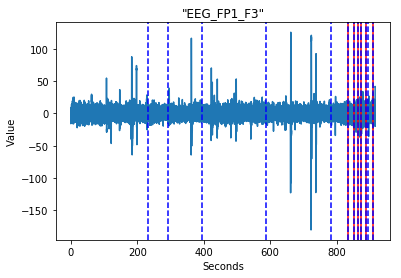

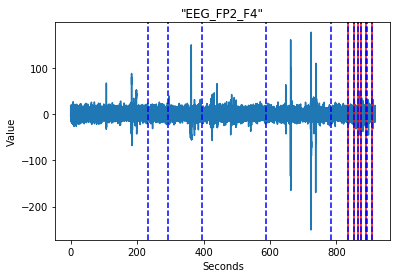

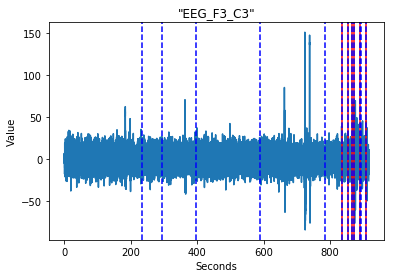

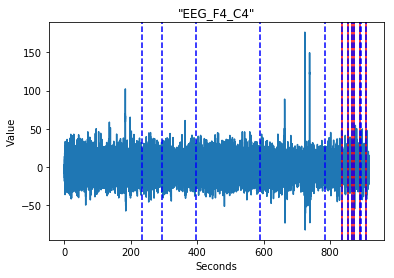

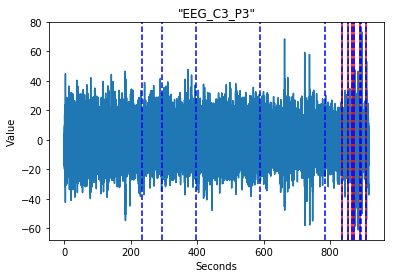

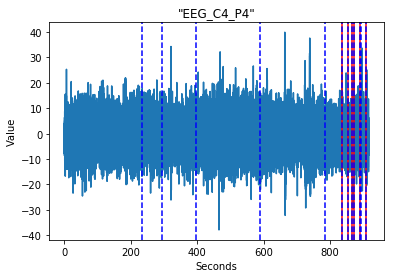

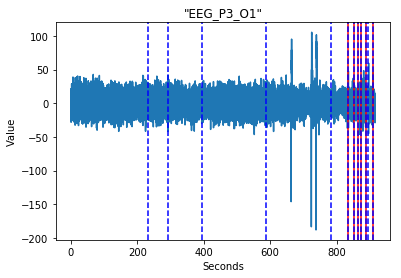

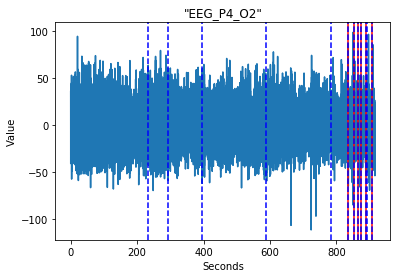

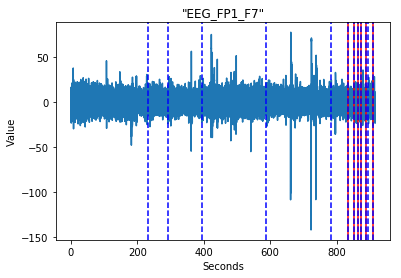

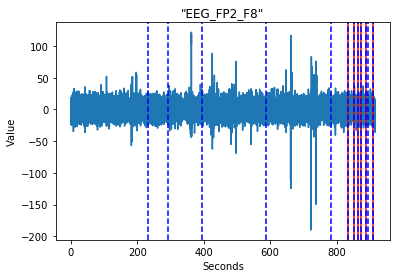

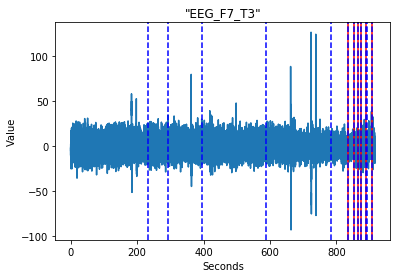

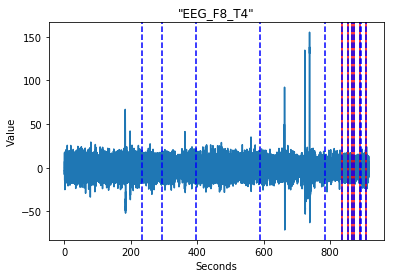

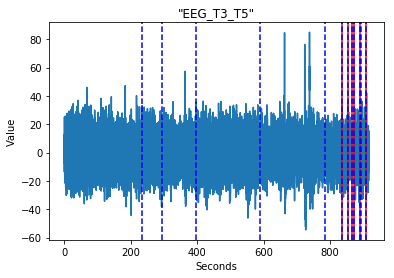

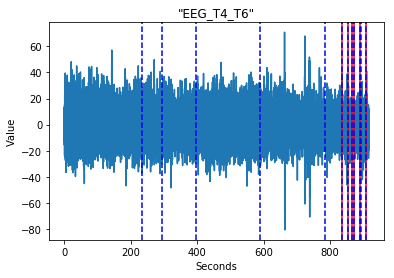

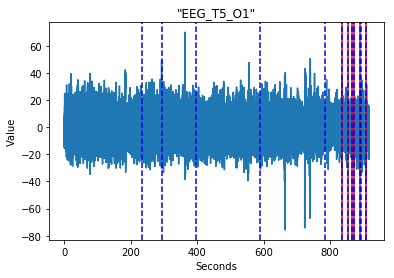

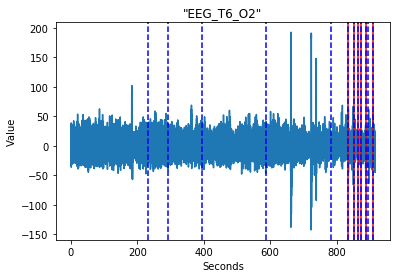

In [18]:
draw_plots_with_chunks(input_data, target, headers, patient=0, chunks_input = chunks_input, to_pdf=False)